In [12]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [13]:
class npyDataset(Dataset):
    def __init__(self, path):
        super(npyDataset, self).__init__()
        
        self.x_list = []
        self.y_list = []
        i = 0

        # in loop, load label and .npy
        for dir in os.listdir(path):
            for np_ in os.listdir(os.path.join(path, dir)):
                self.x_list.append(np.load(os.path.join(path, dir, np_)))
                self.y_list.append(i)
            i += 1
        assert len(self.x_list) == len(self.y_list)
        
    def __len__(self):
        return len(self.x_list)
    

    def __getitem__(self, idx):
        torch_x = torch.from_numpy(self.x_list[idx]).float()
        torch_y = self.y_list[idx]
        return torch_x, torch_y

In [32]:

#for each directory, make dataset
data0 = npyDataset(r'C:\Users\bell9\Desktop\deep\static_dataset\static_data0\data0np')
data1 = npyDataset(r'C:\Users\bell9\Desktop\deep\static_dataset\static_data1\data1np')
data2 = npyDataset(r'C:\Users\bell9\Desktop\deep\static_dataset\static_data2\data2np')
data3 = npyDataset(r'C:\Users\bell9\Desktop\deep\static_dataset\static_data3\data3np')
data4 = npyDataset(r'C:\Users\bell9\Desktop\deep\static_dataset\static_data4\data4np')

In [33]:
# concatenate all dataset
entire_dataset = torch.utils.data.ConcatDataset([data0, data1, data2, data3, data4])

In [34]:
# check dataset size and label completeness
label_set = set()
print(len(entire_dataset))
for i in range(len(entire_dataset)):
    _, label = entire_dataset[i]
    label_set.add(label)
print(len(label_set))

17138
24


In [35]:
#dataset split
trainset, validset = torch.utils.data.random_split(entire_dataset, [12000, 5138])

In [36]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
print("Training data size : {}".format(len(trainset)))

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
print("Validation data size : {}".format(len(validset)))


Training data size : 12000
Validation data size : 5138


In [62]:
class static_model(nn.Module):
    def __init__(self):
        super(static_model, self).__init__()
        self.fc1 = nn.Linear(42, 32)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(32, 24)
        self.alphabet_index = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]        

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    # only for inference
    def test_print(self, x):
        """
        input : 42 length hand coordinate
        output : corresponding Alphabet
        """
        with torch.no_grad():
            cord_numpy = np.array(x)
            cordinate_x = cord_numpy[:21]
            cordinate_y = cord_numpy[21:]
            cordinate_x = (cordinate_x - cordinate_x[0]) / (np.max(cordinate_x) - np.min(cordinate_x))
            cordinate_y = (cordinate_y - cordinate_y[0]) / (np.max(cordinate_y) - np.min(cordinate_y))
            cordinate = np.concatenate((cordinate_x, cordinate_y))
            cord = torch.from_numpy(cordinate).reshape((1, -1))
            out = self.forward(cord)
            _, predicted = torch.max(out, 1)
        return self.alphabet_index[predicted]

            

In [63]:
model = static_model()

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.011)

In [65]:
def train(model, epochs, train_loader, valid_loader, criterion, optimizer, train_loss, valid_loss):
    for epoch in range(epochs):
        model.train()
        t_loss = 0.0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()        
            data, label = data
            x = model(data)
            loss = criterion(x, label)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        t_loss = t_loss / len(train_loader)
        if epoch % 20 == 0:
            print_ = True
            print("Train_loss :", t_loss)
        v_loss = print_accuracy(model, valid_loader, criterion, print_)
        train_loss.append(t_loss)
        valid_loss.append(v_loss)
        print_ = False


# function to calculate accuracy
def print_accuracy(model, dataloader, criterion, printnig):
    model.eval()
    v_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            x, labels = data        
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            v_loss += loss.item()
        v_loss = v_loss / len(dataloader)
    if printnig:
        print("Valid_loss :", v_loss)
        print('Accuracy of the network on the %d test images: %d %%' % (total,
            100.0 * correct / total))  
    return v_loss
    
    

In [66]:
train_loss = []
valid_loss = []
train(model, 100, trainloader, validloader, criterion, optimizer, train_loss, valid_loss)

Train_loss : 2.233104540946636
Valid_loss : 1.2660611413774037
Accuracy of the network on the 5138 test images: 64 %
Train_loss : 0.06486410156209418
Valid_loss : 0.07555895156803585
Accuracy of the network on the 5138 test images: 97 %
Train_loss : 0.030100906941484897
Valid_loss : 0.049300030760821845
Accuracy of the network on the 5138 test images: 99 %
Train_loss : 0.015653869929782887
Valid_loss : 0.04224769232262458
Accuracy of the network on the 5138 test images: 99 %
Train_loss : 0.011198508810806782
Valid_loss : 0.05160614762765666
Accuracy of the network on the 5138 test images: 98 %


In [67]:
# sabe model
checkpoint_dir = './pt-static'
os.makedirs(checkpoint_dir, exist_ok=True)
pt_path = os.path.join(checkpoint_dir, "static.pt")
torch.save(model.state_dict(), pt_path)

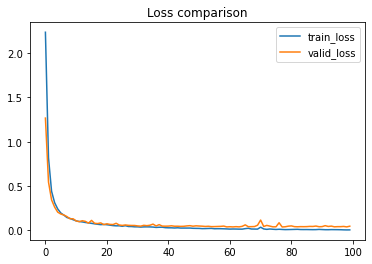

In [70]:
# Loss visualization

epochs = range(100)
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, valid_loss, label = "valid_loss")
plt.title("Loss comparison")
plt.legend()
plt.show()
